<a href="https://colab.research.google.com/github/VictorComitti/IBMEC--data-mining-e-IA/blob/main/codigos%20python/aula%2001/relatorio_ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Carregando os dados


In [1]:
import pandas as pd
import yfinance as yf

ibovespa_data = yf.download('^BVSP', start='2017-01-01')

ibovespa_data = ibovespa_data[['Close']].copy()
ibovespa_data['retorno'] = ibovespa_data['Close'].pct_change() * 100

ibovespa_data = ibovespa_data.reset_index()

ibovespa_data = ibovespa_data.dropna()

print(ibovespa_data.head())

[*********************100%***********************]  1 of 1 completed

Price                       Date    Close   retorno
Ticker                              ^BVSP          
1      2017-01-03 00:00:00+00:00  61814.0  3.733911
2      2017-01-04 00:00:00+00:00  61589.0 -0.363995
3      2017-01-05 00:00:00+00:00  62071.0  0.782607
4      2017-01-06 00:00:00+00:00  61665.0 -0.654090
5      2017-01-09 00:00:00+00:00  61700.0  0.056758


Gerando o gráfico de série temporal

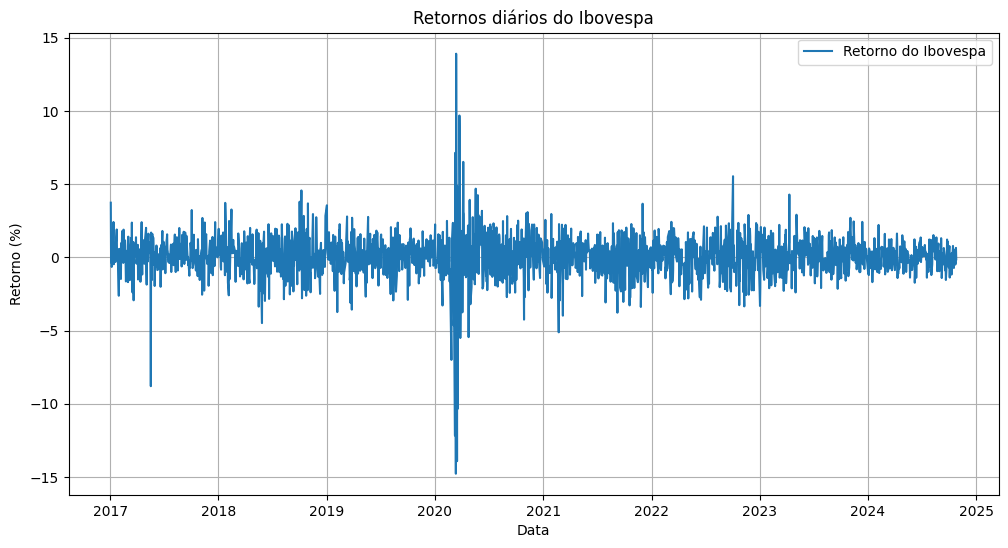

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ibovespa_data['Date'], ibovespa_data['retorno'], label='Retorno do Ibovespa')
plt.title('Retornos diários do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.legend()
plt.grid(True)
plt.show()

O conjunto de dados é composto pelos retornos do Ibovespa entre 03/01/2017 e 09/08/2024. A série temporal mostra um grande cluster de volatilidade no primeiro trimestre de 2020, o que sugere que o conjunto de dados contém outliers. Além disso, retornos em geral são assimétricos. Para verificar essas hipóteses, inicialmente vamos visualizar a distribuição empírica dos dados e calcular as estatísticas descritivas.

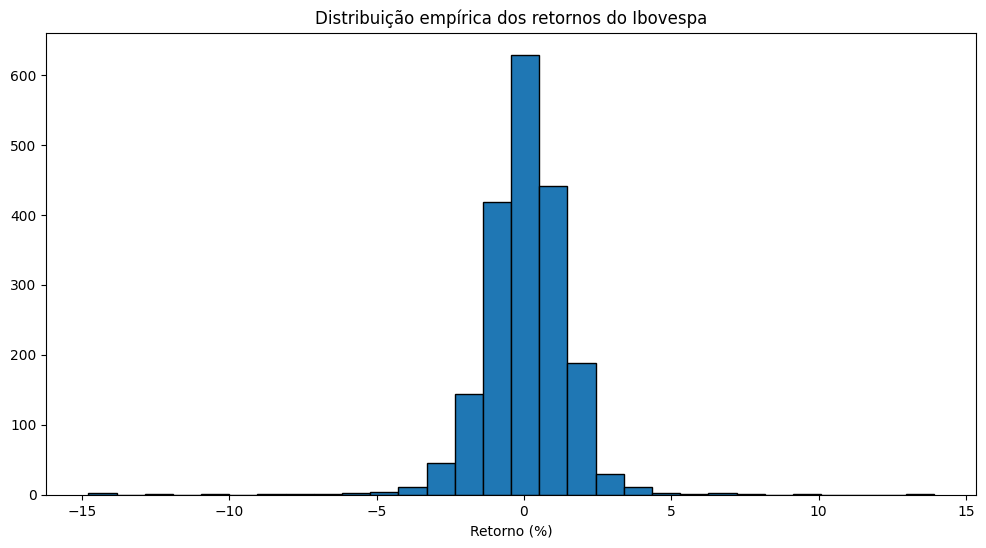

In [5]:
plt.figure(figsize=(12, 6))
plt.hist(ibovespa_data['retorno'], bins=30, edgecolor='k')
plt.title('Distribuição empírica dos retornos do Ibovespa')
plt.xlabel('Retorno (%)')
plt.show()

Podemos observar que a maior parte dos retornos se encontra próximo de zero, mas com uma cauda mais longa para os retornos negativos, indicando assimetria negativa. Em seguida vamos calcular as estatísticas descritivas do conjunto de dados para ganhar intuição sobre ele.


In [15]:
media = ibovespa_data['retorno'].mean(numeric_only=True)
mediana = ibovespa_data['retorno'].median(numeric_only=True)
desvio_padrao = ibovespa_data['retorno'].std(numeric_only=True)
maximo = ibovespa_data['retorno'].max(numeric_only=True)
minimo = ibovespa_data['retorno'].min(numeric_only=True)
Q1 = ibovespa_data['retorno'].quantile(0.25)
Q3 = ibovespa_data['retorno'].quantile(0.75)
variancia = ibovespa_data['retorno'].var(numeric_only=True)
assimetria = ibovespa_data['retorno'].skew(numeric_only=True)
curtose = ibovespa_data['retorno'].kurtosis(numeric_only=True)

tabela_estatisticas = pd.DataFrame({
    'Estatística': ['Média', 'Mediana', 'Desvio Padrão', 'Máximo', 'Mínimo',
                    'Q1', 'Q3', 'variancia', 'assimetria', 'curtose'],
    'Valor': [media, mediana, desvio_padrao, maximo, minimo, Q1, Q3,
              variancia, assimetria, curtose]
})

tabela_estatisticas['Valor'] = tabela_estatisticas['Valor'].round(2)

print(tabela_estatisticas.to_string(index=False))


  Estatística  Valor
        Média   0.05
      Mediana   0.07
Desvio Padrão   1.50
       Máximo  13.91
       Mínimo -14.78
           Q1  -0.69
           Q3   0.84
    variancia   2.26
   assimetria  -0.96
      curtose  17.95


A distribuição dos retornos apresenta uma assimetria negativa (-0,96), o que indica que a mediana (0,07%) é maior que a média (0,05%). Isso significa que, em 50% dos dias, o IBOVESPA teve um retorno de 0,07% ou mais. A assimetria negativa, por sua vez, puxa a média para baixo, refletindo uma maior frequência de retornos negativos mais extremos.

O desvio padrão dos retornos é de 1,52%, e, aplicando a desigualdade de Chebyshev, podemos afirmar que no mínimo 75% dos retornos estão a uma distância de até dois desvios padrão em relação à média. Para os dados analisados, isso se traduz em **pelo menos** 75% dos retornos situados dentro do intervalo [0.05−2×1.52,0.05+2×1.52]=[-3.99%, 4.09%].

Para identificar possíveis outliers vamos, inicialmente, traçar um boxplot (mais sobre isso adiante).

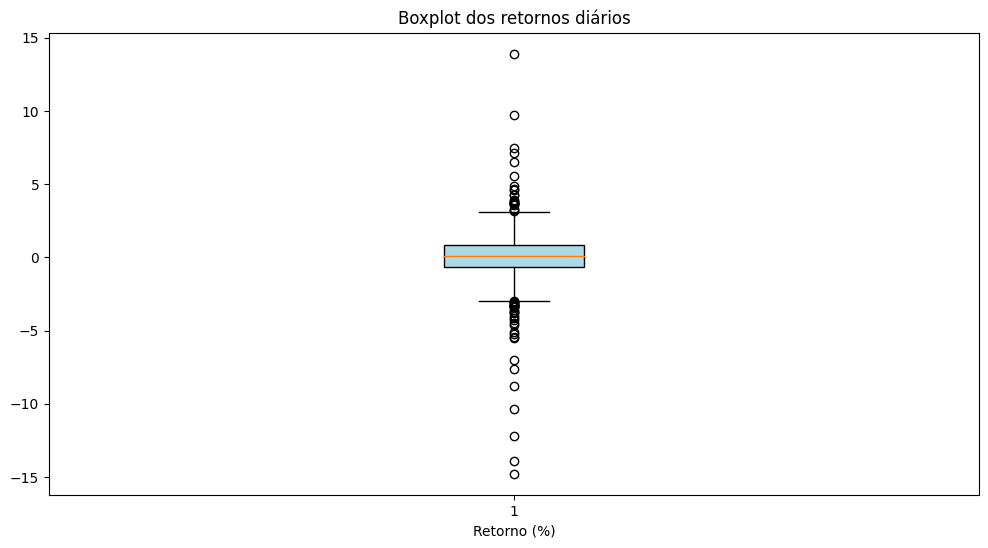

In [22]:
plt.figure(figsize=(12, 6))
box = plt.boxplot(ibovespa_data['retorno'], vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
plt.title('Boxplot dos retornos diários')
plt.xlabel('Retorno (%)')
plt.show()



A figura mostra claramente a existência de vários outliers. Para identificá-los vamos usar a regra da distância interquartil.

In [23]:
Q1 = ibovespa_data['retorno'].quantile(0.25)
Q3 = ibovespa_data['retorno'].quantile(0.75)
IQR = Q3 - Q1

outliers = ibovespa_data[(ibovespa_data['retorno'] < Q1 - 1.5 * IQR) |
                         (ibovespa_data['retorno'] > Q3 + 1.5 * IQR)]
print(outliers)

Price                       Date     Close    retorno
Ticker                               ^BVSP           
1      2017-01-03 00:00:00+00:00   61814.0   3.733911
92     2017-05-18 00:00:00+00:00   61597.0  -8.799230
188    2017-10-03 00:00:00+00:00   76763.0   3.231576
263    2018-01-24 00:00:00+00:00   83680.0   3.720965
275    2018-02-14 00:00:00+00:00   83543.0   3.268273
339    2018-05-17 00:00:00+00:00   83622.0  -3.368501
346    2018-05-28 00:00:00+00:00   75356.0  -4.489341
353    2018-06-07 00:00:00+00:00   73851.0  -2.976996
434    2018-10-02 00:00:00+00:00   81612.0   3.800366
438    2018-10-08 00:00:00+00:00   86084.0   4.569860
453    2018-10-30 00:00:00+00:00   86886.0   3.686289
492    2019-01-02 00:00:00+00:00   91012.0   3.555702
516    2019-02-06 00:00:00+00:00   94636.0  -3.738137
546    2019-03-22 00:00:00+00:00   93735.0  -3.095245
549    2019-03-27 00:00:00+00:00   91903.0  -3.571616
757    2020-01-27 00:00:00+00:00  114482.0  -3.289518
777    2020-02-26 00:00:00+0

Pelo método do 1.5*IQR esse conjunto de dados possui 53 outliers. Nenhuma dessas observações deriva de um erro de medida ou da anotação incorreta de dados. Qualquer modelagem adicional desse conjunto de dados deve levar em consideração a presença de observações discrepantes.